# Import the libraries 

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm.notebook import tqdm

# Loading the custom trained model

In [14]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = './yolov5/runs/train/exp/weights/last.pt', force_reload = True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\DELL/.cache\torch\hub\master.zip
YOLOv5  2022-11-15 Python-3.10.6 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### Testing the model on test images

In [15]:
import os
image_path = os.path.join('.\data\HardHat_Test_Images\Images', 'hard_hat_workers210.png')

image 1/1: 415x416 10 helmets
Speed: 17.0ms pre-process, 166.5ms inference, 0.0ms NMS per image at shape (1, 3, 640, 640)


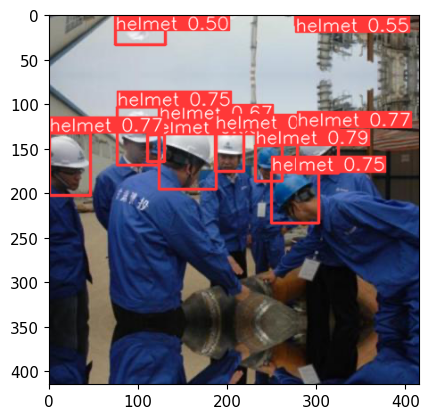

In [16]:
%matplotlib inline

results = model(image_path)
results.print()

img = np.squeeze(results.render())
plt.imshow(img)

# Function for getting the bounding box area

In [17]:
def bounding_box_img(img,bbox):
    x_min, y_min, x_max, y_max = bbox 
    
    y_max = y_max - (y_max - y_min) // 2
    bbox_obj = img[y_min:y_max, x_min:x_max]
    return bbox_obj

In [18]:
def unique_count_app(a):
    '''
    a: NumPy array i.e. the ROI from your image
    Returns: tuple (r, g, b)
    '''
    colors, count = np.unique(
        a.reshape(-1, a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]



def closest(color):
    '''
    Parameter:
    colour: tuple (r, g, b)
    Returns:
    a list, which has [r, g, b] value for closest color from the passed `color` and name of colour
    '''
    color_map = {0: "blue",
                 1: "yellow",
                 2: "orange",
                 3: "white"}
    
    colors = np.array([[0, 128, 255], 
                       [232, 215, 0], 
                       [255, 145, 0], 
                       [255, 255, 255]])
    color = np.array(color)
    distances = np.sqrt(np.sum((colors-color)**2, axis=1))
    index_of_smallest = np.where(distances == np.amin(distances))
    idx = index_of_smallest[0][0]
    return colors[idx], color_map[idx]

## Testing

image 1/1: 415x416 10 helmets
Speed: 11.0ms pre-process, 174.3ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)


[231 147 261 187   0   0]


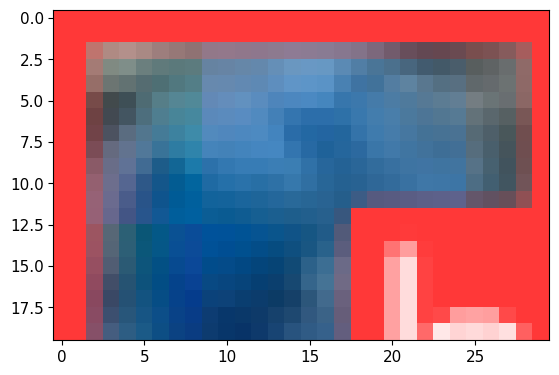

In [19]:
results = model(image_path)
results.print()

bbox = np.array(np.int64(results.xyxy[0][0]))
print(bbox)
cropped_img = bounding_box_img(img,bbox[:4])
plt.imshow(cropped_img)

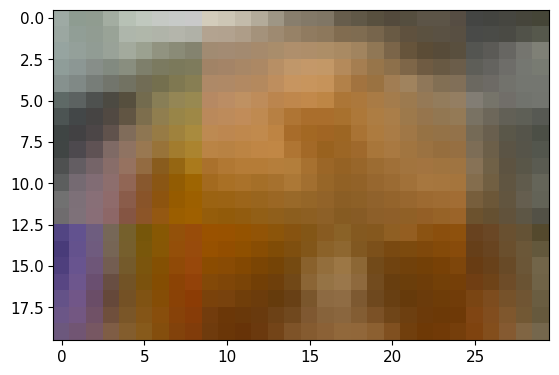

In [20]:
img = cv2.imread(image_path)

cropped_img = bounding_box_img(img,bbox[:4])
plt.imshow(cropped_img)

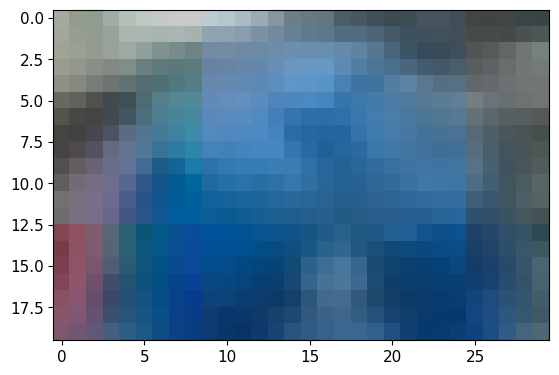

In [21]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cropped_img = bounding_box_img(img_rgb,bbox[:4])
plt.imshow(cropped_img)

In [22]:
color_tuple = unique_count_app(cropped_img)
print(color_tuple)
color = closest(color_tuple)
print(color)

[ 39  96 141]
(array([  0, 128, 255]), 'blue')


In [23]:
"""
    just for this case
"""
confidence_score = np.array(results.xyxy[0][0])
print(confidence_score)

img_rect_drawn = cv2.imread(image_path)

x_min, y_min, x_max, y_max = bbox[:4]
colooo = (255,255- 128, 0)
# cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)
cv2.rectangle(img_rect_drawn, (int(x_min), int(y_min)), (int(x_max), int(y_max)), colooo, 2)

cv2.putText(img_rect_drawn, str(round(float(confidence_score[4]),2)),(int(x_min), int(y_min)) , cv2.FONT_HERSHEY_SIMPLEX, 0.5, colooo, 1, cv2.LINE_AA)

cv2.imshow("im", img_rect_drawn)
cv2.waitKey()
cv2.destroyAllWindows()
bbox[4]

[     231.67      147.76      261.82      187.02     0.78696           0]


0

# Trying to draw bounding box on video with helmet's colour

In [24]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
  
# fontScale
fontScale = 1.5
   
# Blue color in BGR
color = (255 - 173,255 - 86,255 - 77)
  
# Line thickness of 2 px
thickness = 2

"""
    Creating dictionary to get the help in printing the output label
"""
output_dict = {
    '0' : 'helmet',
    '1' : 'head',
    '2' : 'person'
}

In [25]:
# get the input 
cap = cv2.VideoCapture('sample.mp4')

# get the properties
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*"vp80")
# using the videWriter class of openCV

video_writer = cv2.VideoWriter("browser_video.webm", fourcc, fps, (width, height))

for frame_index in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    # read the frame
    
    ret, frame = cap.read()
    frame_copy = frame.copy()
    """
        passing the current frame to trained model and squeezing the results into 3-D for RGB
    """
    results = model(frame)
    frame = np.squeeze(results.render())
    
    """
    Predictions are stored in a list
    """
    bounding_box_result = results.pred[0]
    
    
    for coordinates in bounding_box_result:
        print(coordinates[:4])
        x_min, y_min, x_max, y_max = coordinates[:4]
        bbox = np.array(np.int64(coordinates[:4]))
        
        """
            Choosing the colour according to the colour of helmet
        """
        img_rgb = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
        cropped_img = bounding_box_img(img_rgb,bbox[:4])
#       plt.imshow(cropped_img)

        color_tuple = unique_count_app(cropped_img)
#         print(color_tuple)
        bgr_color_array = closest(color_tuple)[0]
        bgr_color_array = np.flip(bgr_color_array).tolist()
#         color_tuple = np.absolute(255 - bgr_color_array).tolist()
#         color_for_bbox = (int(bgr_color_array[0]), int(bgr_color_array[1]), int(bgr_color_array[2]))
            
            
        """
            for confidence score and output label
        """
#         label_value = str(int(output_dict[f{coordinates[-1]}]))
        text = str(round(float(coordinates[4]),2)) + output_dict[str(int(coordinates[-1]))]
        org = (int(x_min), int(y_min))
        colooo = (255-255,255- 145,   255)
        # cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)
        cv2.rectangle(frame_copy, (int(x_min), int(y_min)), (int(x_max), int(y_max)), bgr_color_array, 2)
        cv2.putText(frame_copy, text, org, font, fontScale, bgr_color_array, thickness, cv2.LINE_AA)
    
    cv2.imshow("VIDEO PLAYER", frame_copy)
    
#     video_writer.write(frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

# release video write
# video_writer.release()

tensor([ 910.95624,   99.61296, 1106.52820,  293.04205])
tensor([1018.36761,  206.35707, 1280.00000,  458.86005])
tensor([740.33716,  33.46423, 903.43225, 202.08490])
tensor([738.51196,  26.09325, 904.76978, 221.54091])
tensor([136.40955,  94.28255, 358.46228, 298.60004])
tensor([ 25.17073, 253.85638, 281.57916, 550.58276])
tensor([1036.86255,  206.85027, 1277.05640,  480.25024])
tensor([407.31555,   0.00000, 589.83948, 228.60153])
tensor([ 904.14111,   94.85760, 1121.01538,  314.07343])
tensor([742.68689,  17.76217, 906.48694, 224.30771])
tensor([134.24243,  83.74107, 351.73129, 307.09177])
tensor([402.97888,   0.00000, 591.96997, 212.93097])
tensor([ 12.75168, 254.51123, 283.25760, 549.43860])
tensor([ 908.20734,   90.30475, 1124.61987,  310.44437])
tensor([1036.57166,  205.95233, 1276.25623,  496.01514])
tensor([135.59909,  79.67439, 345.52896, 307.78693])
tensor([744.09875,  13.65009, 914.95422, 227.28574])
tensor([402.87683,   0.00000, 591.12921, 214.12039])
tensor([ 909.95941,   